In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim

In [11]:
altitude = [0, 2.58, 5.16, 7.73, 12.89, 15.46]  # km
r0_500 = 0.16  # m
weights = [0.652, 0.172, 0.055, 0.025, 0.074, 0.022]
speed = np.random.uniform(0, 20, size=6)  # m/s
direction = [np.random.uniform(0, 360)*galsim.degrees for i in range(6)]
npix = 8192
screen_scale = r0_500
atm = galsim.Atmosphere(
    r0_500=r0_500,
    r0_weights=weights,
    screen_size=screen_scale*npix,
    altitude=altitude,
    L0=25.0,
    speed=speed,
    direction=direction,
    screen_scale=screen_scale)

In [46]:
def _makePSF(x, y, scale):
    """Make an atmospheric PSF.
    
    Parameters
    ----------
    x, y : float
        Location in image in pixel coordinates.
    scale : float
        The pixel scale in arcseconds.
    """
    return galsim.Convolve(
        galsim.Gaussian(fwhm=0.45),
        atm.makePSF(
            lam=700.0, 
            exptime=15.0, 
            time_step=0.005,
            diam=8.4, 
            obscuration=0.6,
            theta=((x * scale) * galsim.arcsec, (y * scale) * galsim.arcsec)))

In [58]:
import tqdm

n = 20
s = np.linspace(0, 225, n)
fwhms = np.zeros((n, n))
for i in tqdm.trange(n):
    sx = s[i]
    for j, sy in enumerate(s):
        psf_im = _makePSF(sx, sy, 0.2).drawImage(
            nx=33, ny=33, scale=0.2, method='phot', n_photons=1e6)
        fwhms[j, i] = psf_im.calculateFWHM()

100%|██████████| 20/20 [06:23<00:00, 18.75s/it]


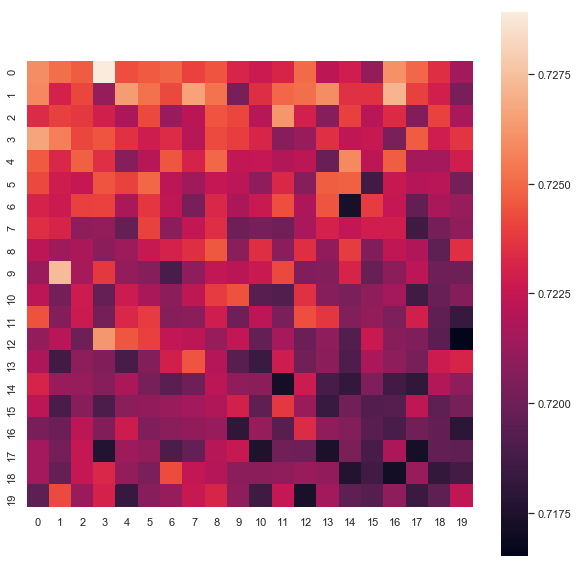

In [59]:
plt.figure(figsize=(10, 10))
sns.heatmap(fwhms, square=True)

In [80]:
import treecorr

In [182]:
x = []
y = []
k = []
mn = np.mean(fwhms)
s = np.linspace(0, 225*0.2, fwhms.shape[0])
for i, sx in enumerate(s):
    for j, sy in enumerate(s):
        x.append(sx)
        y.append(sy)
        k.append((fwhms[j, i] - mn))

cat = treecorr.Catalog(x=np.array(x), y=np.array(y), k=np.array(k))

In [183]:
config = {'nbins': 25, 'min_sep': 1, 'max_sep': 60.0, 'bin_slop': 0.001}

In [184]:
kk = treecorr.KKCorrelation(config=config)

In [185]:
kk.process(cat)

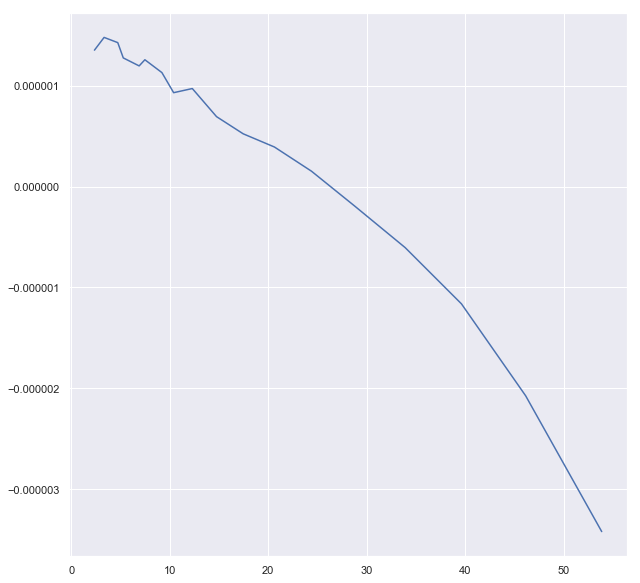

In [186]:
msk = kk.npairs > 0

plt.figure(figsize=(10, 10))
plt.plot(kk.meanr[msk], kk.xi[msk])

In [159]:
galsim.PowerSpectrum.buildGrid?